# Demand Side Response (DSR) Tutorial

This tutorial demonstrates how PyPSA-GB models **domestic Demand Side Response (DSR)** - households reducing electricity consumption during peak periods in exchange for incentive payments.

DSR programs like National Grid ESO's **"Saving Sessions"** provide crucial flexibility during winter peak demand by:
- Reducing demand during critical 2-hour windows (typically 17:00-19:00)
- Helping avoid blackouts and expensive peaker plants
- Providing households with bill savings (£3-10/event)

The HT35_flex scenario includes **1,500 MW of domestic DSR capacity**, representing household participation in demand response events.

## What You'll Learn

1. DSR configuration modes (regular, winter, both)
2. Event scheduling patterns and frequency
3. DSR dispatch behavior and system value
4. Comparison with other flexibility mechanisms (EV, batteries)
5. Configuration parameters and capacity sizing

## 1. Setup

In [12]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Load Network with DSR

The HT35_flex scenario includes event-based demand flexibility representing domestic DSR participation.

In [13]:
# Load solved network with DSR enabled
n = pypsa.Network("../../../resources/network/HT35_flex_solved.nc")

print("Network loaded")
print(f"  Buses: {len(n.buses)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Period: {n.snapshots[0]} to {n.snapshots[-1]}")
print(f"  Snapshots: {len(n.snapshots)}")

INFO:pypsa.network.io:Imported network 'HT35_flex (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Buses: 298
  Generators: 1671
  Period: 2035-01-13 00:00:00 to 2035-01-19 23:00:00
  Snapshots: 168


## 3. DSR Configuration

Let's examine how DSR is configured in the HT35_flex scenario.

In [14]:
# Load configuration
with open("../../../config/defaults.yaml") as f:
    defaults = yaml.safe_load(f)

with open("../../../config/scenarios.yaml") as f:
    scenarios = yaml.safe_load(f)

# Get DSR configuration
dsr_defaults = defaults.get('demand_flexibility', {}).get('event_response', {})
scenario_dsr = scenarios.get('HT35_flex', {}).get('demand_flexibility', {}).get('event_response', {})

# Effective configuration (scenario overrides defaults)
eff_enabled = scenario_dsr.get('enabled', dsr_defaults.get('enabled', False))
eff_mode = scenario_dsr.get('mode', dsr_defaults.get('mode', 'regular'))
eff_capacity = scenario_dsr.get('dsr_capacity_mw', dsr_defaults.get('dsr_capacity_mw', None))
eff_window = scenario_dsr.get('event_window', dsr_defaults.get('event_window', ['17:00', '19:00']))
eff_winter_months = dsr_defaults.get('winter_months', [10, 11, 12, 1, 2, 3])

print("=" * 70)
print("HT35_FLEX DSR CONFIGURATION")
print("=" * 70)

print(f"\nENABLED: {eff_enabled}")

print(f"\nMODE: '{eff_mode}'")
if eff_mode == 'regular':
    print("  → 2 events per week throughout the year")
elif eff_mode == 'winter':
    print(f"  → 5 events per week during winter months {eff_winter_months}")
elif eff_mode == 'both':
    print(f"  → 2 events/week year-round + 5 events/week in winter {eff_winter_months}")

print(f"\nCAPACITY:")
if eff_capacity:
    print(f"  dsr_capacity_mw = {eff_capacity} MW (user-defined)")
else:
    part_rate = dsr_defaults.get('participation_rate', 0.33)
    max_red = dsr_defaults.get('max_reduction_fraction', 0.10)
    print(f"  Calculated from: participation_rate ({part_rate}) × max_reduction ({max_red})")

print(f"\nEVENT WINDOW:")
print(f"  {eff_window[0]} - {eff_window[1]} (peak demand period)")

print(f"\nWINTER MONTHS (for 'winter' or 'both' modes):")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
winter_names = [month_names[m-1] for m in eff_winter_months]
print(f"  {', '.join(winter_names)}")

print("\n" + "=" * 70)

HT35_FLEX DSR CONFIGURATION

ENABLED: True

MODE: 'regular'
  → 2 events per week throughout the year

CAPACITY:
  dsr_capacity_mw = 1500 MW (user-defined)

EVENT WINDOW:
  17:00 - 19:00 (peak demand period)

WINTER MONTHS (for 'winter' or 'both' modes):
  Oct, Nov, Dec, Jan, Feb, Mar



## 4. DSR Components in PyPSA

DSR is modeled as **Generator components** with:
- **p_nom**: Maximum demand reduction capacity (MW)
- **p_max_pu**: Time-varying availability (0 or 1, only during events)
- **carrier**: 'demand response'
- **marginal_cost**: High cost (£500/MWh) = only dispatch when needed

These generators represent households reducing consumption, which appears as "negative demand" or "generation" in the model.

In [15]:
# Find DSR generators
dsr_gens = n.generators[n.generators.carrier == 'demand response']

print(f"DSR Generators: {len(dsr_gens)}")
print(f"Total DSR Capacity: {dsr_gens.p_nom.sum():.1f} MW")
print(f"Average per bus: {dsr_gens.p_nom.mean():.2f} MW")
print(f"Marginal cost: £{dsr_gens.marginal_cost.iloc[0]:.0f}/MWh (incentive payment)")

# Show sample DSR generators
print("\nSample DSR Generators:")
print(dsr_gens[['bus', 'carrier', 'p_nom', 'marginal_cost']].head(10))

DSR Generators: 251
Total DSR Capacity: 1500.0 MW
Average per bus: 5.98 MW
Marginal cost: £0/MWh (incentive payment)

Sample DSR Generators:
                                        bus          carrier      p_nom  \
name                                                                      
ABHA11 demand response                ABHA1  demand response   8.547520   
ABNE3- demand response               ABNE_P  demand response   1.060794   
ABTH11 demand response               ABTH_1  demand response   5.987351   
ALNE3J demand response               ALNE_P  demand response   1.129311   
ALST31 demand response__agg4  ALST_3|USKM_1  demand response   6.338699   
ALVE11 demand response                ALVE1  demand response  12.171143   
AMEM11 demand response__agg2        WATFS_1  demand response  11.116036   
ARBR3- demand response               ARBR_P  demand response   1.004420   
ARMO3- demand response__agg2         DUGR_P  demand response   1.441006   
AXMI11 demand response            

## 5. Event Schedule

DSR events are pre-scheduled based on the mode configuration. Let's visualize when events occur.

Event Schedule Statistics:
  Total event hours: 4
  Event days: 2
  Average events/week: 2.0


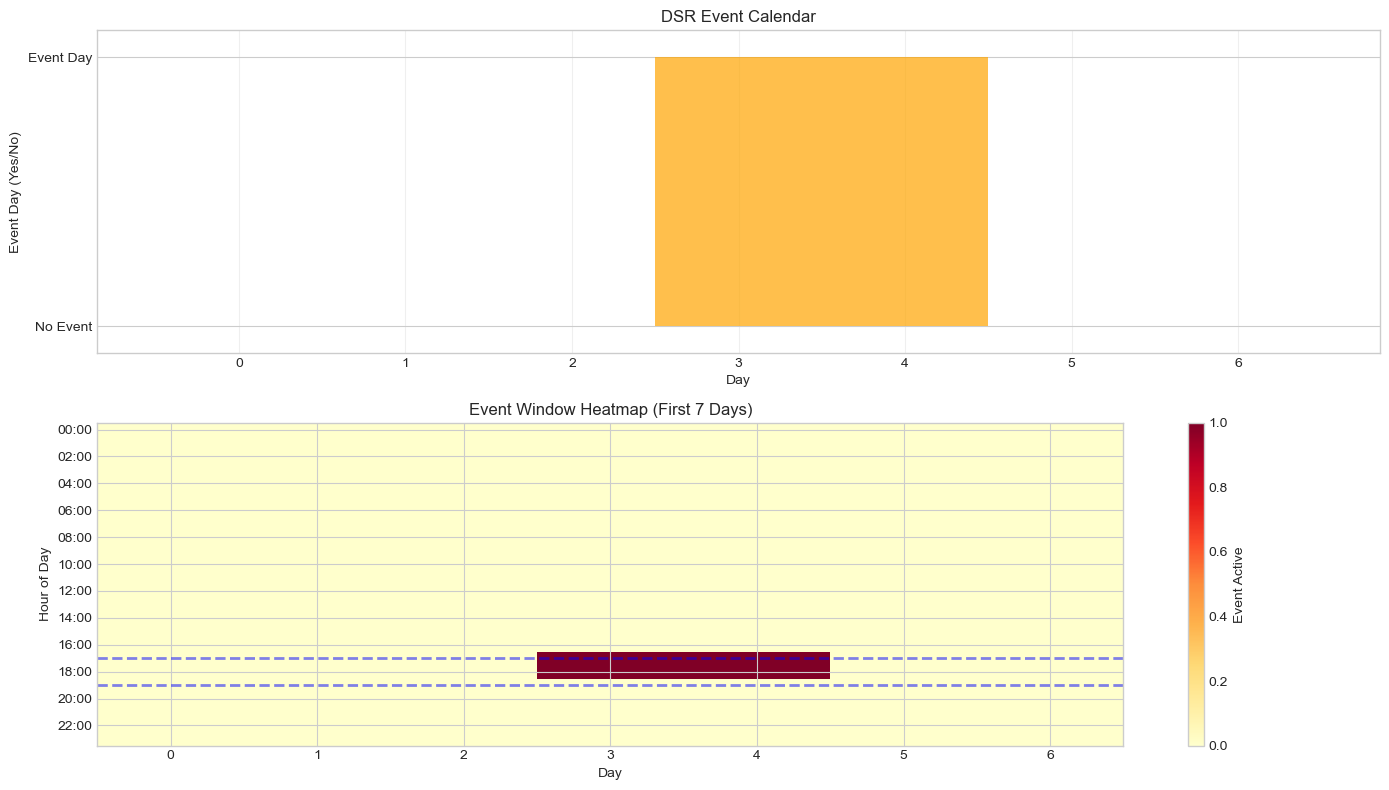

In [16]:
# Get DSR availability schedule from first generator's p_max_pu
if len(dsr_gens) > 0 and len(n.generators_t.p_max_pu) > 0:
    sample_gen = dsr_gens.index[0]
    
    if sample_gen in n.generators_t.p_max_pu.columns:
        event_schedule = n.generators_t.p_max_pu[sample_gen]
        
        # Count events
        total_event_hours = event_schedule.sum()
        event_days = (event_schedule.groupby(event_schedule.index.date).sum() > 0).sum()
        
        print(f"Event Schedule Statistics:")
        print(f"  Total event hours: {total_event_hours:.0f}")
        print(f"  Event days: {event_days}")
        print(f"  Average events/week: {event_days / (len(n.snapshots) / (7*24)):.1f}")
        
        # Plot event calendar
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Daily event occurrence
        daily_events = event_schedule.groupby(event_schedule.index.date).sum()
        axes[0].bar(range(len(daily_events)), daily_events.values > 0, 
                   color='orange', alpha=0.7, width=1.0)
        axes[0].set_ylabel('Event Day (Yes/No)')
        axes[0].set_xlabel('Day')
        axes[0].set_title('DSR Event Calendar')
        axes[0].set_ylim(-0.1, 1.1)
        axes[0].set_yticks([0, 1])
        axes[0].set_yticklabels(['No Event', 'Event Day'])
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Hourly heatmap (first N complete days available)
        # Calculate how many complete days we can display
        available_hours = min(336, len(event_schedule))  # Up to 2 weeks (336 hours)
        available_days = available_hours // 24
        available_hours = available_days * 24  # Round down to complete days
        
        if available_hours >= 24:
            first_n_hours = event_schedule.iloc[:available_hours]
            heatmap_data = first_n_hours.values.reshape((available_days, 24)).T
            
            im = axes[1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto', 
                               interpolation='nearest', vmin=0, vmax=1)
            axes[1].set_ylabel('Hour of Day')
            axes[1].set_xlabel('Day')
            axes[1].set_title(f'Event Window Heatmap (First {available_days} Days)')
            axes[1].set_yticks(range(0, 24, 2))
            axes[1].set_yticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
            
            # Highlight typical event window
            window_start = int(eff_window[0].split(':')[0])
            window_end = int(eff_window[1].split(':')[0])
            axes[1].axhline(y=window_start, color='blue', linestyle='--', alpha=0.5, linewidth=2)
            axes[1].axhline(y=window_end, color='blue', linestyle='--', alpha=0.5, linewidth=2)
            
            plt.colorbar(im, ax=axes[1], label='Event Active')
        else:
            # Not enough data for heatmap
            axes[1].text(0.5, 0.5, f'Insufficient data for heatmap\n({available_hours} hours available, need ≥24)',
                        ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
            axes[1].set_title('Event Window Heatmap')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No p_max_pu data available for DSR generators")
else:
    print("No DSR generators found")


## 6. DSR Dispatch Analysis

Now let's analyze when and how much DSR was actually dispatched by the optimizer.

DSR DISPATCH SUMMARY

Capacity vs Utilization:
  Total DSR capacity: 1500.0 MW
  Peak dispatch: 1.47 GW
  Peak utilization: 98.1%

Energy Delivered:
  Total DSR energy: 5.8 GWh
  Hours with DSR > 0: 4
  Average during events: 1.46 GW


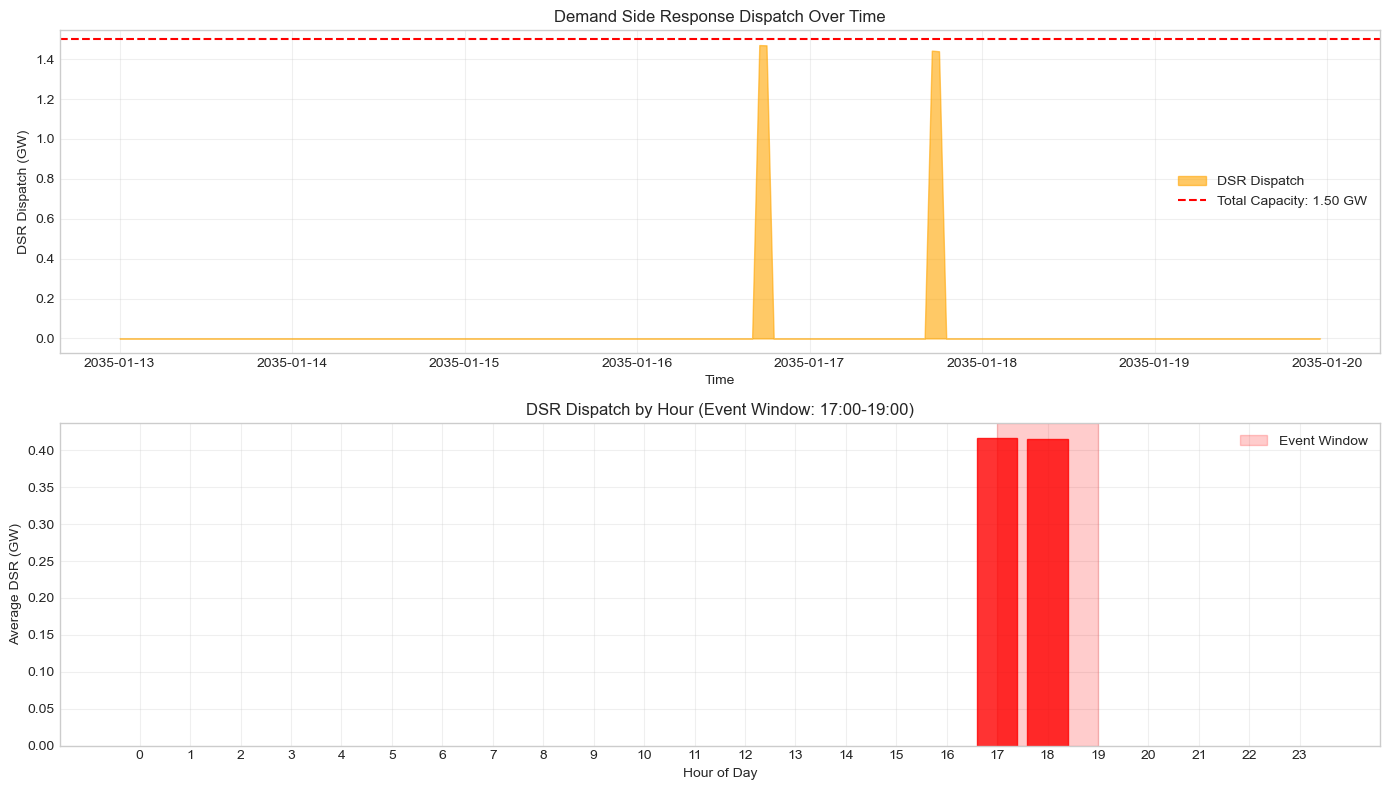

In [17]:
# Get DSR dispatch (actual demand reduction)
if len(dsr_gens) > 0 and len(n.generators_t.p) > 0:
    dsr_cols = [c for c in n.generators_t.p.columns if c in dsr_gens.index]
    
    if dsr_cols:
        # Total DSR dispatch across all buses
        total_dsr = n.generators_t.p[dsr_cols].sum(axis=1) / 1000  # GW
        
        print("=" * 70)
        print("DSR DISPATCH SUMMARY")
        print("=" * 70)
        
        print(f"\nCapacity vs Utilization:")
        print(f"  Total DSR capacity: {dsr_gens.p_nom.sum():.1f} MW")
        print(f"  Peak dispatch: {total_dsr.max():.2f} GW")
        print(f"  Peak utilization: {total_dsr.max() / (dsr_gens.p_nom.sum()/1000) * 100:.1f}%")
        
        print(f"\nEnergy Delivered:")
        print(f"  Total DSR energy: {total_dsr.sum():.1f} GWh")
        print(f"  Hours with DSR > 0: {(total_dsr > 0.001).sum()}")
        print(f"  Average during events: {total_dsr[total_dsr > 0.001].mean():.2f} GW")
        
        # Plot dispatch time series
        fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
        
        # Full time series
        axes[0].fill_between(total_dsr.index, total_dsr.values, 
                            alpha=0.6, color='orange', label='DSR Dispatch')
        axes[0].axhline(y=dsr_gens.p_nom.sum()/1000, color='red', linestyle='--',
                       label=f'Total Capacity: {dsr_gens.p_nom.sum()/1000:.2f} GW')
        axes[0].set_ylabel('DSR Dispatch (GW)')
        axes[0].set_xlabel('Time')
        axes[0].set_title('Demand Side Response Dispatch Over Time')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Average by hour of day
        dsr_by_hour = total_dsr.groupby(total_dsr.index.hour).mean()
        
        bars = axes[1].bar(dsr_by_hour.index, dsr_by_hour.values, 
                          color='orange', alpha=0.7)
        
        # Highlight event window
        window_start = int(eff_window[0].split(':')[0])
        window_end = int(eff_window[1].split(':')[0])
        for hour in range(window_start, window_end):
            if hour < len(bars):
                bars[hour].set_color('red')
                bars[hour].set_alpha(0.8)
        
        axes[1].set_ylabel('Average DSR (GW)')
        axes[1].set_xlabel('Hour of Day')
        axes[1].set_title(f'DSR Dispatch by Hour (Event Window: {eff_window[0]}-{eff_window[1]})')
        axes[1].set_xticks(range(0, 24, 1))
        axes[1].grid(True, alpha=0.3)
        
        # Add annotation for event window
        axes[1].axvspan(window_start, window_end, alpha=0.2, color='red', 
                       label='Event Window')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 70)
    else:
        print("No DSR dispatch data found")
else:
    print("No DSR generators found")

## 7. DSR Value Analysis

When does DSR get dispatched? Compare DSR activation with system marginal prices to understand its value.

DSR VALUE ANALYSIS

Price Statistics:
  Average price when DSR active: £20.13/MWh
  Average price when DSR inactive: £12.33/MWh
  Price premium captured: £7.80/MWh

Dispatch Triggers:
  Min price during DSR: £9.98/MWh
  Max price during DSR: £30.22/MWh
  DSR marginal cost: £0/MWh

Economic Value:
  Value of DSR (at marginal price): £118
  Cost of DSR (incentive payments): £0
  Net system benefit: £118


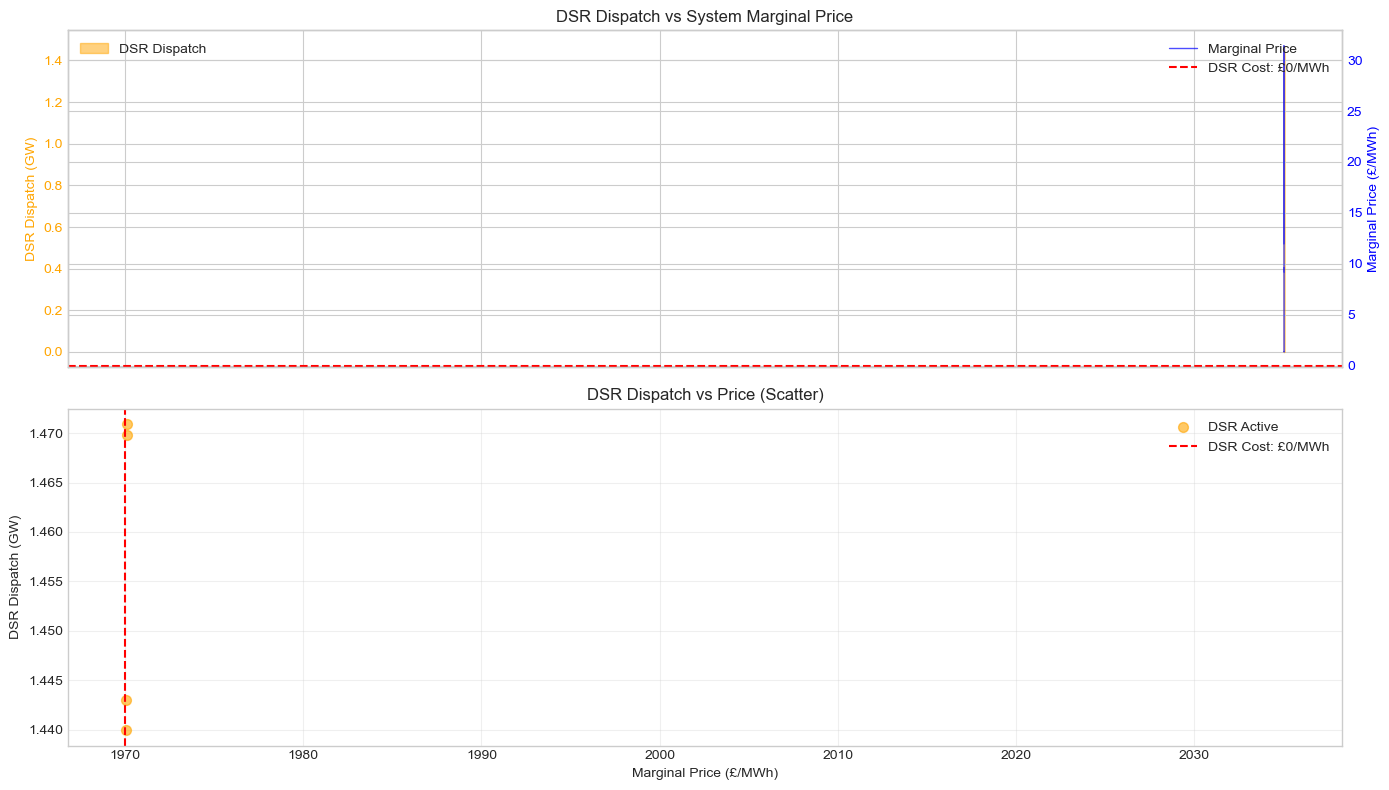

In [18]:
# Compare DSR dispatch with marginal prices
if len(dsr_gens) > 0 and len(n.generators_t.p) > 0 and len(n.buses_t.marginal_price) > 0:
    dsr_cols = [c for c in n.generators_t.p.columns if c in dsr_gens.index]
    
    if dsr_cols:
        total_dsr = n.generators_t.p[dsr_cols].sum(axis=1) / 1000  # GW
        
        # Average marginal price across all buses
        avg_price = n.buses_t.marginal_price.mean(axis=1)
        
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'dsr_gw': total_dsr,
            'price': avg_price
        })
        
        # When is DSR active?
        dsr_active = comparison[comparison['dsr_gw'] > 0.001]
        dsr_inactive = comparison[comparison['dsr_gw'] <= 0.001]
        
        print("DSR VALUE ANALYSIS")
        print("=" * 70)
        
        if len(dsr_active) > 0:
            print(f"\nPrice Statistics:")
            print(f"  Average price when DSR active: £{dsr_active['price'].mean():.2f}/MWh")
            print(f"  Average price when DSR inactive: £{dsr_inactive['price'].mean():.2f}/MWh")
            print(f"  Price premium captured: £{dsr_active['price'].mean() - dsr_inactive['price'].mean():.2f}/MWh")
            
            print(f"\nDispatch Triggers:")
            print(f"  Min price during DSR: £{dsr_active['price'].min():.2f}/MWh")
            print(f"  Max price during DSR: £{dsr_active['price'].max():.2f}/MWh")
            print(f"  DSR marginal cost: £{dsr_gens.marginal_cost.iloc[0]:.0f}/MWh")
            
            # Total value delivered
            total_value = (dsr_active['dsr_gw'] * dsr_active['price']).sum()
            total_cost = (dsr_active['dsr_gw'] * dsr_gens.marginal_cost.iloc[0]).sum()
            print(f"\nEconomic Value:")
            print(f"  Value of DSR (at marginal price): £{total_value:,.0f}")
            print(f"  Cost of DSR (incentive payments): £{total_cost:,.0f}")
            print(f"  Net system benefit: £{total_value - total_cost:,.0f}")
            
            # Plot price vs DSR
            fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
            
            # Time series overlay
            ax1 = axes[0]
            ax1.fill_between(comparison.index, comparison['dsr_gw'], 
                            alpha=0.5, color='orange', label='DSR Dispatch')
            ax1.set_ylabel('DSR Dispatch (GW)', color='orange')
            ax1.tick_params(axis='y', labelcolor='orange')
            
            ax2 = ax1.twinx()
            ax2.plot(comparison.index, comparison['price'], 
                    color='blue', linewidth=1, alpha=0.7, label='Marginal Price')
            ax2.axhline(y=dsr_gens.marginal_cost.iloc[0], color='red', 
                       linestyle='--', label=f'DSR Cost: £{dsr_gens.marginal_cost.iloc[0]:.0f}/MWh')
            ax2.set_ylabel('Marginal Price (£/MWh)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.legend(loc='upper right')
            
            ax1.set_title('DSR Dispatch vs System Marginal Price')
            ax1.legend(loc='upper left')
            
            # Scatter plot: price vs DSR
            axes[1].scatter(dsr_active['price'], dsr_active['dsr_gw'], 
                          alpha=0.6, c='orange', s=50, label='DSR Active')
            axes[1].axvline(x=dsr_gens.marginal_cost.iloc[0], color='red', 
                          linestyle='--', label=f'DSR Cost: £{dsr_gens.marginal_cost.iloc[0]:.0f}/MWh')
            axes[1].set_xlabel('Marginal Price (£/MWh)')
            axes[1].set_ylabel('DSR Dispatch (GW)')
            axes[1].set_title('DSR Dispatch vs Price (Scatter)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("\n" + "=" * 70)
        else:
            print("No DSR was dispatched during this period")
    else:
        print("No DSR dispatch data")
else:
    print("Marginal price data not available")

## 8. Geographic Distribution of DSR

DSR capacity is distributed across network buses proportionally to peak demand. Let's visualize this.

DSR Distribution Across 251 Buses
  Total capacity: 1500.0 MW
  Top 10 buses: 235.4 MW (15.7%)
  Min capacity: 0.02 MW
  Max capacity: 38.23 MW
  Mean capacity: 5.98 MW
  Median capacity: 3.28 MW


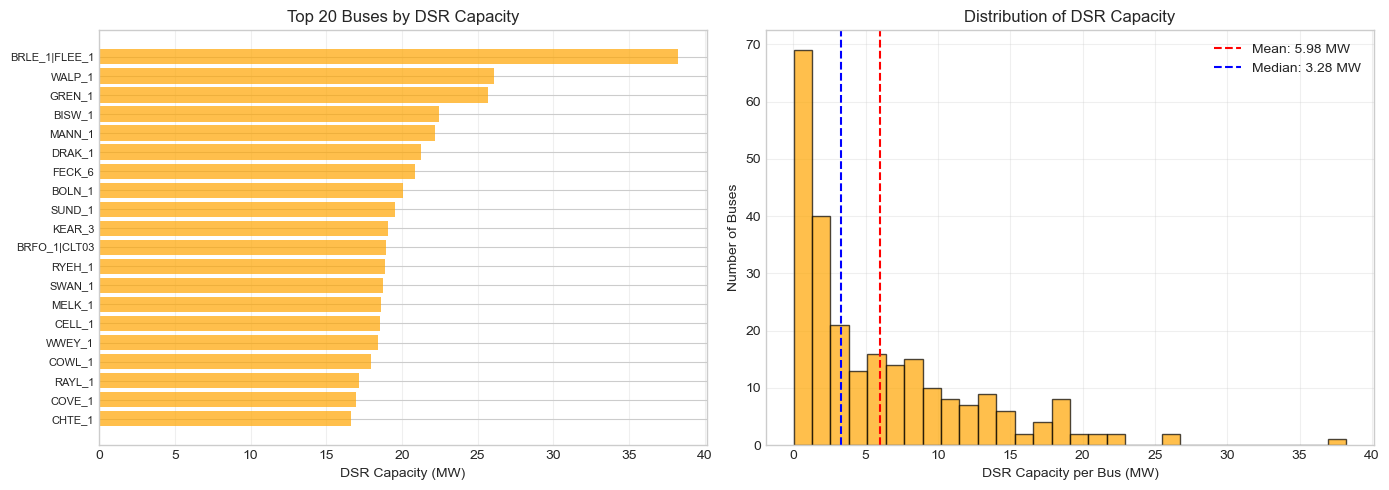


Top 10 Buses:
   1. BRLE_1|FLEE_1  :    38.23 MW
   2. WALP_1         :    26.08 MW
   3. GREN_1         :    25.67 MW
   4. BISW_1         :    22.43 MW
   5. MANN_1         :    22.19 MW
   6. DRAK_1         :    21.28 MW
   7. FECK_6         :    20.84 MW
   8. BOLN_1         :    20.05 MW
   9. SUND_1         :    19.52 MW
  10. KEAR_3         :    19.10 MW


In [19]:
# Analyze DSR distribution across buses
if len(dsr_gens) > 0:
    # Group by bus
    dsr_by_bus = dsr_gens.groupby('bus')['p_nom'].sum().sort_values(ascending=False)
    
    print(f"DSR Distribution Across {len(dsr_by_bus)} Buses")
    print(f"  Total capacity: {dsr_by_bus.sum():.1f} MW")
    print(f"  Top 10 buses: {dsr_by_bus.head(10).sum():.1f} MW ({dsr_by_bus.head(10).sum()/dsr_by_bus.sum()*100:.1f}%)")
    print(f"  Min capacity: {dsr_by_bus.min():.2f} MW")
    print(f"  Max capacity: {dsr_by_bus.max():.2f} MW")
    print(f"  Mean capacity: {dsr_by_bus.mean():.2f} MW")
    print(f"  Median capacity: {dsr_by_bus.median():.2f} MW")
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Top 20 buses
    top20 = dsr_by_bus.head(20)
    axes[0].barh(range(len(top20)), top20.values, color='orange', alpha=0.7)
    axes[0].set_yticks(range(len(top20)))
    axes[0].set_yticklabels(top20.index, fontsize=8)
    axes[0].set_xlabel('DSR Capacity (MW)')
    axes[0].set_title('Top 20 Buses by DSR Capacity')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Histogram of capacity distribution
    axes[1].hist(dsr_by_bus.values, bins=30, color='orange', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=dsr_by_bus.mean(), color='red', linestyle='--',
                   label=f'Mean: {dsr_by_bus.mean():.2f} MW')
    axes[1].axvline(x=dsr_by_bus.median(), color='blue', linestyle='--',
                   label=f'Median: {dsr_by_bus.median():.2f} MW')
    axes[1].set_xlabel('DSR Capacity per Bus (MW)')
    axes[1].set_ylabel('Number of Buses')
    axes[1].set_title('Distribution of DSR Capacity')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Buses:")
    for i, (bus, capacity) in enumerate(dsr_by_bus.head(10).items(), 1):
        print(f"  {i:2d}. {bus:15s}: {capacity:>8.2f} MW")
else:
    print("No DSR generators found")

## 9. Configuration Reference

DSR is configured in `config/defaults.yaml` under `demand_flexibility.event_response`:

```yaml
event_response:
  enabled: false                    # Toggle DSR on/off
  mode: "regular"                   # regular, winter, or both
  event_window: ["17:00", "19:00"]  # Peak period (typically 17:00-19:00)
  dsr_capacity_mw: null             # User-defined capacity (MW)
  participation_rate: 0.33          # Fallback: 33% of households participate
  max_reduction_fraction: 0.10      # Fallback: 10% max demand reduction
  winter_months: [10, 11, 12, 1, 2, 3]  # Oct-Mar for winter mode
```

### Key Parameters:

| Parameter | Description | Typical Value |
|-----------|-------------|---------------|
| `enabled` | Turn DSR on/off | false (opt-in) |
| `mode` | Event frequency | regular, winter, both |
| `dsr_capacity_mw` | Total DSR capacity | 1000-2000 MW |
| `event_window` | Daily event period | ["17:00", "19:00"] |
| `participation_rate` | Household participation (fallback) | 0.2-0.4 |
| `max_reduction_fraction` | Max demand reduction (fallback) | 0.05-0.15 |
| `winter_months` | Winter months for 'winter'/'both' modes | [10,11,12,1,2,3] |

### Mode Comparison:

| Mode | Frequency | Use Case |
|------|-----------|----------|
| **regular** | 2 events/week year-round | Baseline flexibility testing |
| **winter** | 5 events/week Oct-Mar | High winter demand periods |
| **both** | 2/week summer + 5/week winter | Most realistic scenario |

### Capacity Sizing:

If `dsr_capacity_mw` is not set, capacity is calculated as:
```
DSR Capacity = participation_rate × max_reduction_fraction × Peak Demand
```

For GB with ~40 GW peak demand:
- Conservative: 0.25 × 0.08 × 40,000 MW = **800 MW**
- Moderate: 0.33 × 0.10 × 40,000 MW = **1,320 MW**
- Ambitious: 0.40 × 0.12 × 40,000 MW = **1,920 MW**

The HT35_flex scenario uses **1,500 MW** as a realistic mid-point target for 2035.

## 10. Real-World Context: National Grid ESO Saving Sessions

PyPSA-GB's DSR modeling is inspired by real programs like **National Grid ESO's Demand Flexibility Service** ("Saving Sessions"):

### How Saving Sessions Works:

1. **Enrollment**: Households with smart meters sign up through their energy supplier
2. **Event notification**: ESO announces events 24 hours in advance (typically 17:00-19:00)
3. **Baseline establishment**: Smart meter calculates typical usage for that period
4. **Demand reduction**: Households reduce usage (delay cooking, heating, EV charging)
5. **Reward payment**: £3-10 per kWh saved, paid via energy supplier

### Winter 2022/23 Results:

- **1.6 million households** participated
- **21 events** held (Nov 2022 - Mar 2023)
- **~500 MW** average reduction per event
- **3,300 MWh** total energy saved
- **£50/MWh** average cost (vs. £150-300/MWh for backup generation)

### 2035 Projection (HT35 Scenario):

- **5-10 million households** with smart meters and flexibility tariffs
- **1,500 MW** achievable reduction (3x current)
- **50-100 events/year** (winter-focused)
- **Cost-effective** alternative to peaker plants and imports

### Why DSR is Valuable:

1. **Avoids generation costs**: £50-100/MWh vs. £150-300/MWh for backup
2. **Reduces network stress**: Temporal load shifting prevents bottlenecks
3. **Consumer benefits**: Households earn rewards for flexibility
4. **Low carbon**: Reduces need for fossil fuel peaker plants
5. **Scalable**: Can grow with smart meter rollout